## Kmeans

My Kmeans implementation was created in its own notebook, and as such uses a seperate memory space / kernel. This notebook imports the CIFAR-10 image dataset and separates the data into two sets containing 50000 train / 10000 test images. The data is not shuffled, since it was not required to be (except in the 5-fold validation section). The Kmeans machine learning algorithm is then used to train on the 50000 train images, and classify on the 10000 test images (using various values of k). The accuracies of the predictions for each k value are calculated and compared.

#### Import statements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose
from collections import Counter
import cv2

In [2]:
import ssl #This is for resolving a known certificate error with CIFAR-10 in torchvision 
ssl._create_default_https_context = ssl._create_unverified_context 

The ssl code above is for resolving a known certificate error with CIFAR-10 in torchvision 

#### RGB values for Grayscale conversion

In [3]:
#Global colour values for greyscale conversion
RED = 0.299
BLUE = 0.114
GREEN = 0.587

#### Seed value for shuffling data

In [4]:
seedval = 2022 #seed used for picking random centroids and in k-fold validation

#### Importing and partitioning data into test and train datasets

The data is imported and stored in two arrays. Each image of the dataset is a 32x32 image, and each pixel has BGR values.

In [5]:
train_dataset = datasets.CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
X_train = train_dataset.data
y_train = np.array(train_dataset.targets)
X_test = test_dataset.data
y_test = np.array(test_dataset.targets)
classes = train_dataset.classes

#### Function Definitions

##### Grayscale conversion function to be performed on every pixel when called in preProcess function

In [7]:
def toBWArray(itemarray):
    global RED,BLUE,GREEN
    val = np.uint8(np.dot(itemarray, [BLUE,GREEN,RED]))
    return val

##### Pre-processing of each image. Flattens the array, converts it to grayscale, and scales each pixel value between 0-1.

In [8]:
def preProcess(itemarray):
    arr_copy = np.empty((len(itemarray), 32, 32, 3))
    np.copyto(arr_copy, itemarray)
    arr_copy = arr_copy.reshape((len(itemarray), 1024, 3))
    bwArray = np.empty((len(itemarray),1024), np.uint8)
    for i in range(len(itemarray)):
        bwArray[i] = toBWArray(arr_copy[i])
    bwArray = bwArray / 256
    return bwArray

##### Distance computation. Calculates the distances between every image in X_test and every image in arr_centroids. In this case, outputs an array of size (10000, k)

In [9]:
def computeDist(X_test, arr_centroids):
    distance_array = np.empty((len(X_test),len(arr_centroids)), np.float32)
    for n in range(len(X_test)):
        results_array = np.empty((len(arr_centroids)))
        for i in range(len(arr_centroids)):
            results_array[i] = np.sqrt(np.sum(np.square(arr_centroids[i] - X_test[n])))
        distance_array[n] = results_array
    return distance_array

##### Computes the cluster value for each image in X_train. Outputs an array of size 50000. The index of the array is the image id in X_train and the value is the id of the centroid it belongs to in arr_centroids.

In [10]:
def computeClusters(X_train, arr_centroids):
    arr_clusters = np.empty((len(X_train)), np.uint8)
    for n in range(len(X_train)):
        distance_array = np.empty((len(arr_centroids)),np.float32)
        for i in range(len(arr_centroids)):
            distance_array[i] = np.sqrt(np.sum(np.square(X_train[n] - arr_centroids[i])))
        distancesortedindexes = np.argsort(distance_array)
        arr_clusters[n] = distancesortedindexes[0]
    return arr_clusters

##### Function that picks the initial centroids for the algorithm. Outputs a semi-random array of images to be used as centroids of size (k). When (k <= the size of the feature set) the chosen images will all be different classes. When (k > the size of the feature set), the shuffled sequence of classes to be chosen will repeat. (Ex. when k = 10, arr_centroids = [8 5 0 9 2 3 7 1 6 4] and when k= 15, arr_centroids = [8 5 0 9 2 3 7 1 6 4 8 5 0 9 2]

In [11]:
def pickCentroids(X_train, y_train):
    global k
    global seedval
    np.random.seed(seedval)
    arr_centroids_id = np.empty((k), np.uint32)
    arr_centroids = np.empty((k, len(X_train[0])))
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    
    shuffled_classes = np.arange(len(classes))
    np.random.shuffle(shuffled_classes)
    picked_classes = np.empty((k), np.uint8)

    for i in range(picked_classes.shape[0]):
        picked_classes[i] = shuffled_classes[int(i % (len(classes)))]
        
    #print(picked_classes[::-1])
    
    loop_c = 0
    while(picked_classes.size != 0):
        if y_train[indices[loop_c]] in picked_classes:
            arr_centroids_id[(len(picked_classes) - 1)] = indices[loop_c]
            index_of_found_value = np.where(picked_classes == y_train[indices[loop_c]])[0]
            if(index_of_found_value.size != 1):
                index_of_found_value = index_of_found_value[0]
            picked_classes = np.delete(picked_classes, index_of_found_value)
        loop_c += 1
    
    for i in range(k):
        arr_centroids[i] = X_train[arr_centroids_id[i]]
        
    #print(arr_centroids_id)
      
    return arr_centroids

##### Function that recomputes the centroids based on the current clusters

In [12]:
def recomputeCentroids(arr_centroids, arr_clusters, X_train):
    avgs = np.zeros((len(arr_centroids),1024), np.float32)
    for i in range(len(arr_clusters)):
        avgs[arr_clusters[i]] += X_train[i]
    arr_count = np.bincount(arr_clusters)
    for j in range(len(avgs)):
        avgs[j] = avgs[j] /  arr_count[j]
    return avgs

##### User-facing function for training the model. Sets up initial centroids, clusters, the base case for recursiveTrain, and calls recursiveTrain. Returns arr_clusters and arr_centroids to be used for classification.

In [13]:
def trainThis(X_train, y_train):
    arr_centroids = pickCentroids(X_train, y_train)
    arr_clusters = computeClusters(X_train, arr_centroids)
    prev_centroids = np.zeros((len(arr_centroids),arr_centroids.shape[1]),np.float32)
    tupled = recursiveTrain(arr_clusters, arr_centroids, prev_centroids, X_train)
    return tupled[0], tupled[1]

##### Recursively trains the model. Returns multiple variables uses in recursion, but only the final arr_clusters and arr_centroids are relevant to the user.

In [14]:
def recursiveTrain(arr_clusters, arr_centroids, prev_centroids, X_train):
    diff = 0.0
    for i in range(len(arr_centroids)):
        diff += (arr_centroids[i] - prev_centroids[i]).sum()
    #print(diff)
    if(diff == 0.0):
        return arr_clusters, arr_centroids, prev_centroids, X_train
    else:
        np.copyto(prev_centroids, arr_centroids)
        arr_clusters = computeClusters(X_train, arr_centroids)
        arr_centroids = recomputeCentroids(arr_centroids, arr_clusters, X_train)
        return recursiveTrain(arr_clusters, arr_centroids, prev_centroids, X_train)

##### Classifies the test data based on arr_clusters, and arr_centroids. Somewhat unintuitively requires y_train to be passed to it because the k features are also labelled in this function. 

In [15]:
def classifyThis(X_train, X_test, y_train, arr_clusters, arr_centroids):
    results_array = np.empty((X_test.shape[0]), np.uint8)
    
    arr_clusters_counts = np.zeros((arr_centroids.shape[0], len(classes)), np.int32)
    for i in range(arr_clusters.shape[0]):
        arr_clusters_counts[arr_clusters[i]][y_train[i]] += 1
        
    centroid_labels = np.empty((arr_centroids.shape[0]), np.uint8)
    
    for i in range(arr_clusters_counts.shape[0]):
        sorted_cluster_indexes = np.argsort(arr_clusters_counts[i])
        centroid_labels[i] = sorted_cluster_indexes[(sorted_cluster_indexes.shape[0] - 1)]

    distance_array = computeDist(X_test, arr_centroids)
    for i in range(distance_array.shape[0]):
        distancesortedindexes = np.argsort(distance_array[i])
        results_array[i] = centroid_labels[distancesortedindexes[0]]
    return results_array

##### Compares the answers of the test set to the predicted set and returns the accuracy of the predicted set

In [16]:
def evalThis(results_array, y_test):
    val = np.sum(results_array == y_test) / len(y_test)
    return val

#### Computation

Both the X_train and X_test arrays are preprocessed.

In [17]:
X_train_proc = preProcess(X_train)
print('X_train preprocessed')
X_test_proc = preProcess(X_test)
print('X_test preprocessed')

X_train preprocessed
X_test preprocessed


The arrays are now reshaped, converted to grayscale, and scaled

In [18]:
k = 3

Global k value is now set

The arr_clusters and arr_centroids are created by training:

In [19]:
arr_clusters, arr_centroids = trainThis(X_train_proc, y_train)

Classify the X_test data and return the predicted results:

In [20]:
results = classifyThis(X_train_proc, X_test_proc, y_train, arr_clusters, arr_centroids)

Accuracy is returned and saved in k3:

In [21]:
k3 = evalThis(results, y_test)
print(k3)

0.1738


The training->classifying->evaluating process is repeated for k = 5,7, and 11

In [22]:
k = 5
arr_clusters, arr_centroids = trainThis(X_train_proc, y_train)
results_array = classifyThis(X_train_proc, X_test_proc, y_train, arr_clusters, arr_centroids)
k5 = evalThis(results_array, y_test)
print(k5)

k = 7
arr_clusters, arr_centroids = trainThis(X_train_proc, y_train)
results_array = classifyThis(X_train_proc, X_test_proc, y_train, arr_clusters, arr_centroids)
k7 = evalThis(results_array, y_test)
print(k7)
        
k = 11
arr_clusters, arr_centroids = trainThis(X_train_proc, y_train)
results_array = classifyThis(X_train_proc, X_test_proc, y_train, arr_clusters, arr_centroids)
k11 = evalThis(results_array, y_test)
print(k11)

0.195
0.206
0.2281


### Accuracy Chart

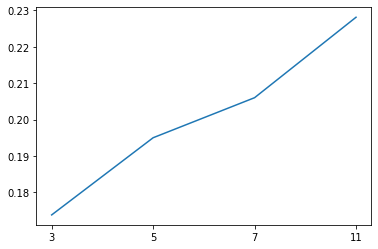

In [23]:
vals = {'3':k3, '5':k5, '7':k7, '11':k11}
plt_x = list(vals.keys())
plt_y = list(vals.values())
plt.plot(plt_x, plt_y)

As we can see, k = 11 has the highest accuracy at around 23%

## 5-fold Validation

In [24]:
def fiveFoldVal(X_train, X_test, y_train, y_test):
    global k
    global seedval
    folds = 5
    np.random.seed(seedval)
    
    X_set_OG = np.concatenate((X_train, X_test))
    y_set_OG = np.concatenate((y_train, y_test))
    
    X_set_OG = preProcess(X_set_OG)
    
    indices = np.arange(X_set_OG.shape[0])
    np.random.shuffle(indices)
    X_set = X_set_OG[indices]
    y_set = y_set_OG[indices]
    
    #size reduction for testing
    X_set = X_set[:1000]
    y_set = y_set[:1000]
    
    #This is assuming (X_set = y_set = 60000) is divisible by (folds = 5)
    #I didn't bother to write the case where it isn't
    subset_size = int(X_set.shape[0] / folds)
    
    X_sets = np.empty((folds, subset_size, 1024), np.float32)
    for i in range(folds):
        X_sets[i] = X_set[(i * subset_size):((i+1) * subset_size)]

    y_sets = np.empty((folds, subset_size), np.uint8)
    for i in range(folds):
        y_sets[i] = y_set[(i * subset_size):((i+1) * subset_size)]
        
    accuracies = np.empty((folds, 4), np.float32)
        
    for i in range(folds):
        print(f'Fold: {(i+1)}')
        X_test = X_sets[i]
        y_test = y_sets[i]
        
        X_train = np.empty(shape=[0, 1024], dtype=np.float32)
        y_train = np.empty(shape=[0], dtype=np.uint8)
        
        for j in range(folds):
            if(j!=i):
                X_train = np.append(X_train, X_sets[j], axis=0)
                y_train = np.append(y_train, y_sets[j])
        
        k = 3
        arr_clusters, arr_centroids = trainThis(X_train, y_train)
        results_array = classifyThis(X_train, X_test, y_train, arr_clusters, arr_centroids)
        k3 = evalThis(results_array, y_test)
        accuracies[i][0] = k3
        print(k3)
        
        k = 5
        arr_clusters, arr_centroids = trainThis(X_train, y_train)
        results_array = classifyThis(X_train, X_test, y_train, arr_clusters, arr_centroids)
        k5 = evalThis(results_array, y_test)
        accuracies[i][1] = k5
        print(k5)
        
        k = 7
        arr_clusters, arr_centroids = trainThis(X_train, y_train)
        results_array = classifyThis(X_train, X_test, y_train, arr_clusters, arr_centroids)
        k7 = evalThis(results_array, y_test)
        accuracies[i][2] = k7
        print(k7)
        
        k = 11
        arr_clusters, arr_centroids = trainThis(X_train, y_train)
        results_array = classifyThis(X_train, X_test, y_train, arr_clusters, arr_centroids)
        k11 = evalThis(results_array, y_test)
        accuracies[i][3] = k11
        print(k11)
        print()
        print()
    return accuracies

In [25]:
accuracies = fiveFoldVal(X_train, X_test, y_train, y_test)

Fold: 1
0.155
0.2
0.205
0.205


Fold: 2
0.15
0.22
0.24
0.195


Fold: 3
0.15
0.17
0.16
0.16


Fold: 4
0.16
0.13
0.17
0.195


Fold: 5
0.13
0.175
0.22
0.225




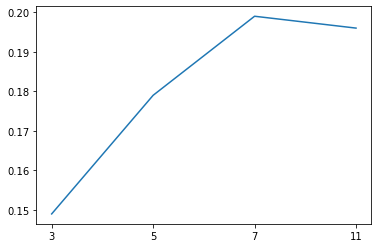

In [26]:
avg_k3 = np.mean(accuracies[:,0])
avg_k5 = np.mean(accuracies[:,1])
avg_k7 = np.mean(accuracies[:,2])
avg_k11 = np.mean(accuracies[:,3])
vals = {'3':avg_k3, '5':avg_k5, '7':avg_k7, '11':avg_k11}
plt_x = list(vals.keys())
plt_y = list(vals.values())
plt.plot(plt_x, plt_y)

After performing 5-fold validation, it seems that the best value of k for Kmeans in this model is between k = 7, and k=11 with around 20% accuracy. This makes sense since k is roughly equal to the size of the classes set.